In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections

import numpy as np
from tqdm import tqdm
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import textblob
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
from nltk import bigrams,trigrams,ngrams
from collections import Counter
from sklearn.metrics import confusion_matrix
from nltk import everygrams, word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

In [2]:
CA_Asian_business_review = pd.read_csv('CA_Asian_business_review.csv')

# Removing stop words & categorize sentiment

In [3]:
#Append more words to stop word list based on word cloud
stop = stopwords.words('english')
stop.append('Santa Barbara')
stop.append('Santa')
stop.append('Barbara')
stop.append('chinese restaurant')
stop.append('korean bbq')
stop.append('Korean bbq')
stop.append('place')

In [4]:
#Remove stopwords
lemm = WordNetLemmatizer()
#stop = set(stopwords.words('english'))

CA_Asian_business_review['text_word_list'] = CA_Asian_business_review['text'].str.split()
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_word_list'].apply(lambda x : [re.sub(r'[.,"\'-?:!;]', '', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [re.sub(r'\<a href', ' ', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [re.sub(r'&amp;', '', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [re.sub(r'<br />', ' ', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [re.sub(r'\'', ' ', i) for i in x])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x : [i for i in x if i not in stop])
CA_Asian_business_review['text_no_stopwords'] = CA_Asian_business_review['text_no_stopwords'].apply(lambda x: [item.lower() for item in x])
CA_Asian_business_review['text_cleaned'] = [' '.join(map(str,l)) for l in CA_Asian_business_review.text_no_stopwords]

def lemmatize_text(text):
    return [lemm.lemmatize(word) for word in nltk.WordPunctTokenizer().tokenize(text)]
CA_Asian_business_review['text_cleaned'] = CA_Asian_business_review.text_cleaned.apply(lemmatize_text)

In [5]:
#Categorize each sentiment
def categorize_sentiment(row):
    if row['comment_star'] > 3:
        return 'Positive'
    elif row['comment_star'] == 3:
        return 'Neutral'
    elif row['comment_star'] < 3:
        return 'Negative'
CA_Asian_business_review['sentiment'] = CA_Asian_business_review.apply(lambda row : categorize_sentiment(row), axis = 1)

# Plot word cloud

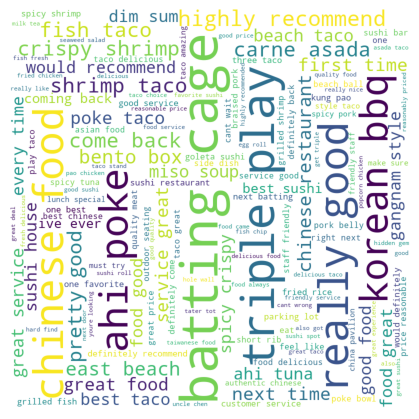

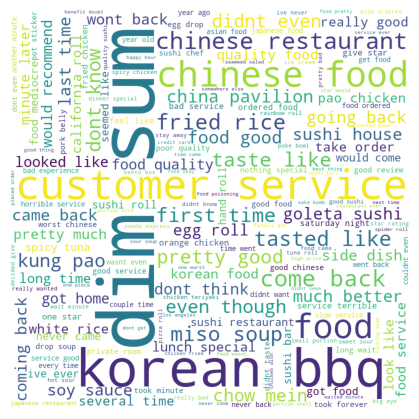

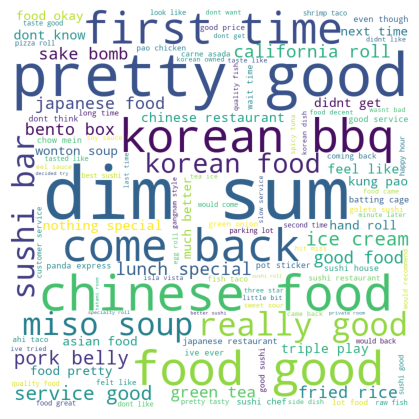

In [6]:
#Plot word cloud
def word_cloud(df, sentiment):
    new_df= df[df['sentiment'] == sentiment].reset_index(drop=True)
    wc = ''
    for i in range(len(new_df)):
        for word in new_df.loc[i,'text_cleaned']:
            wc += ''.join(word)+' '

    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',min_font_size = 10,
                         collocation_threshold = 3, min_word_length=3, stopwords = stop).generate(wc)

    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    # plt.title(sentiment)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
word_cloud(CA_Asian_business_review,'Positive')   
word_cloud(CA_Asian_business_review,'Negative')
word_cloud(CA_Asian_business_review,'Neutral')

# Word sanity check

In [7]:
good_word = ['nice','affordable','delicious','fantastic','excellent','wonderful','terrific']
bad_word = ['bad','terrible','awful','horrible']
neutral_word = ['average','mediocre','adequate','ordinary','decent']

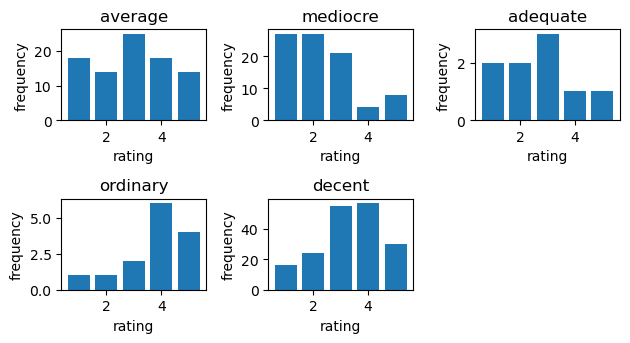

In [8]:
def word_sanity_check (word):
    count_dict = {}
    for i in range(len(CA_Asian_business_review)):
        cur_star = CA_Asian_business_review.loc[i,'comment_star']
        cur_review = CA_Asian_business_review.loc[i,'text_cleaned']
        if cur_star not in count_dict:
            count_dict[cur_star] = 1
        elif word in cur_review:
            count_dict[cur_star] += 1
    count_dict = collections.OrderedDict(sorted(count_dict.items()))
    return count_dict


def word_freq(word_ls):
    ls_len = len(word_ls)
    ls_row = 3
    ls_col = 3
    for i in range(len(word_ls)):
        plt.tight_layout()
        cur_word = word_ls[i]
        cur_dict = word_sanity_check(cur_word)
        plt.subplot(ls_row,ls_col,i+1)
        plt.bar(cur_dict.keys(),cur_dict.values())
        plt.title(cur_word)
        plt.xlabel('rating')
        plt.ylabel('frequency')

    
word_freq(neutral_word)

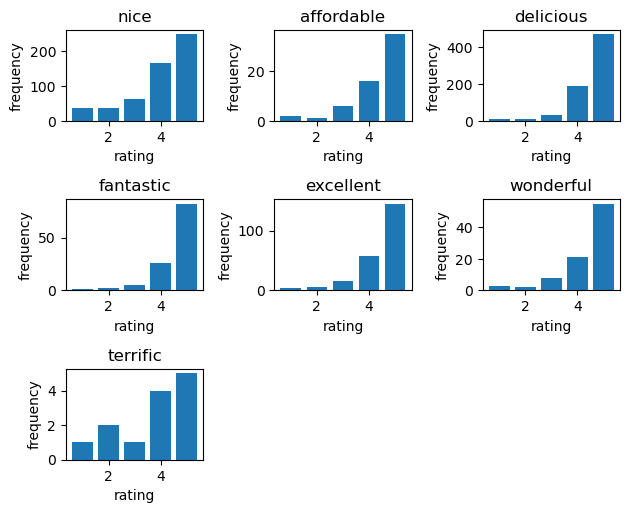

In [9]:
word_freq(good_word)

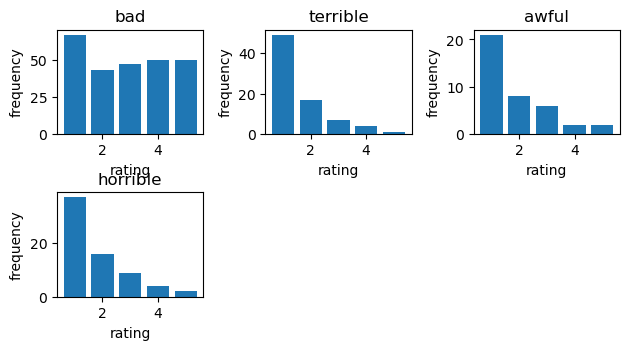

In [10]:
word_freq(bad_word)

# Examine parking with rating

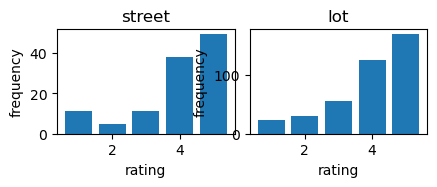

In [11]:
parking_option = ['street','lot']
word_freq(parking_option)

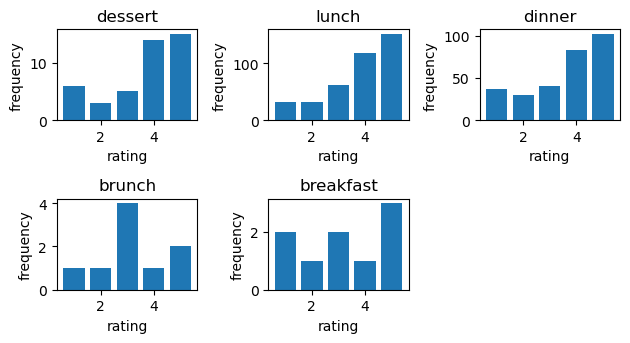

In [12]:
meals_offer = ['dessert','lunch','dinner','brunch','breakfast']
word_freq(meals_offer)

# relationships between lunch/dinner and sentiment

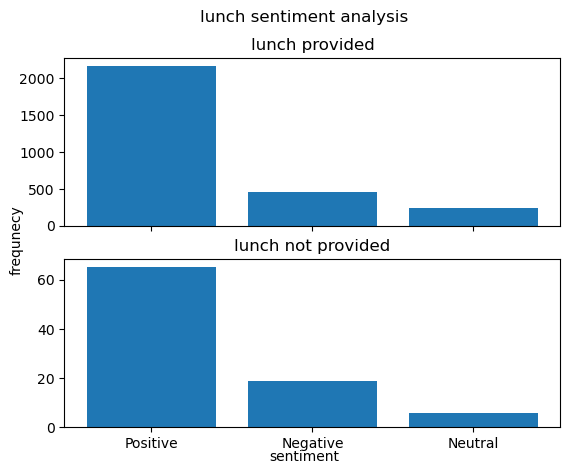

In [13]:
def meal_sentiment_analysis(df, meal):
    new_df = df[df[meal].notna()]
    new_df = df[[meal, 'sentiment']]
    provided =  new_df.loc[new_df[meal] == True].reset_index(drop = True)
    not_provided = new_df.loc[new_df[meal] == False].reset_index(drop = True)
    
    provide_dict = {}
    not_provide_dict = {}
    
    for i in range(len(provided)):
        provided_sentiment = provided.loc[i,'sentiment']
        if provided_sentiment not in provide_dict:
            provide_dict[provided_sentiment] = 1
        else:
            provide_dict[provided_sentiment] += 1
         
    for i in range(len(not_provided)):
        not_provided_sentiment = not_provided.loc[i,'sentiment']
        if not_provided_sentiment not in not_provide_dict:
            not_provide_dict[not_provided_sentiment] = 1
        else:
            not_provide_dict[not_provided_sentiment] += 1
    
    return provide_dict, not_provide_dict



def plot_meal_sentiment_analysis(meal):
    provided_dict, not_provided_dict = meal_sentiment_analysis(CA_Asian_business_review, meal)
    #label = ['Positive','Neutral','Negative']
    
    fig,(ax1,ax2) = plt.subplots(2, sharex='col')
    fig.suptitle(meal + ' sentiment analysis')
    ax1.bar(provided_dict.keys(),provided_dict.values())
    ax2.bar(not_provided_dict.keys(),not_provided_dict.values())
    ax1.title.set_text(meal+ ' provided')
    ax2.title.set_text(meal+' not provided')
    fig.text(0.5, 0.04, 'sentiment', ha='center')
    fig.text(0.04, 0.5, 'frequnecy', va='center', rotation='vertical')


plot_meal_sentiment_analysis('lunch')

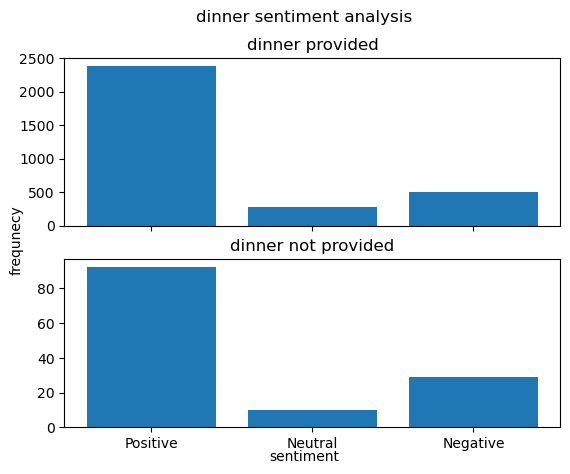

In [14]:
plot_meal_sentiment_analysis('dinner')

# Examine total working hour with rating

In [15]:
CA_Asian_business_review['Total_hour'] = CA_Asian_business_review[['Monday_working_length','Tuesday_working_length',
                                                                  'Wednesday_working_length','Thursday_working_length',
                                                                  'Friday_working_length','Saturday_working_length',
                                                                  'Sunday_working_length']].sum(axis = 1)

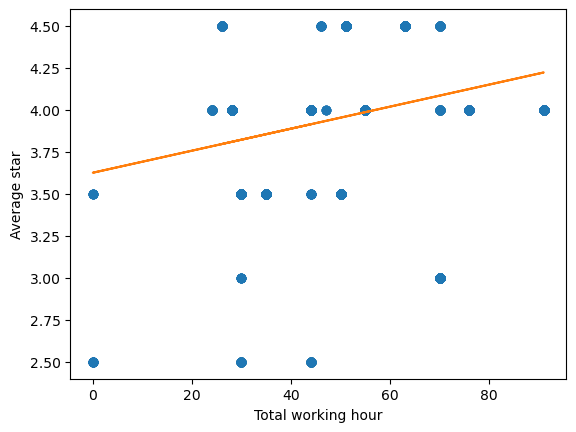

In [16]:
def scatter(df, feature1, feature2):
    df = df[df[feature1].notna()]
    df = df[df[feature2].notna()]
    plt.plot(df[feature1],df[feature2],'o')
    m,b = np.polyfit(df[feature1],df[feature2],1)
    plt.plot(df[feature1],m*df[feature1]+b)
    plt.xlabel('Total working hour')
    plt.ylabel('Average star')

scatter(CA_Asian_business_review,'Total_hour','average_stars')
# plt.plot()

#$CA_Asian_business_review['Total_hour']

In [17]:
CA_Asian_business_review[CA_Asian_business_review['Total_hour'] == 0]['business_id'].unique()

array(['748Tn5Hsf4LMCCA_WxVBfA', 'iFlEWAwE1MwcXREzgLNIsQ'], dtype=object)

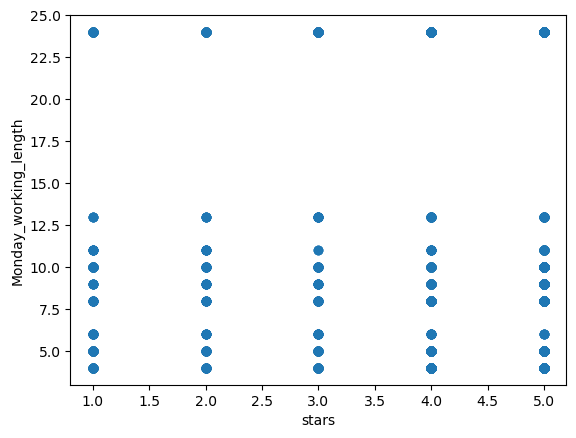

In [18]:
# def get_max(feature):
#     return CA_Asian_business_review[feature].max()

# def get_min(feature):
#     return CA_Asian_business_review[feature].min()

# max_working_hour = [get_max('Monday_working_length'),
#                     get_max('Tuesday_working_length'),
#                     get_max('Wednesday_working_length'),
#                     get_max('Thursday_working_length'),
#                     get_max('Friday_working_length'),
#                     get_max('Saturday_working_length'),
#                     get_max('Sunday_working_length')].max()

# min_working_hour = [get_max('Monday_working_length'),
#                     get_max('Tuesday_working_length'),
#                     get_max('Wednesday_working_length'),
#                     get_max('Thursday_working_length'),
#                     get_max('Friday_working_length'),
#                     get_max('Saturday_working_length'),
#                     get_max('Sunday_working_length')].min()



def scatter(df, feature):
    new_df = df[['comment_star',feature]]
    new_df = new_df.dropna()
    plt.scatter(new_df['comment_star'], new_df[feature] )
    plt.xlabel('stars')
    plt.ylabel(feature)

scatter(CA_Asian_business_review, 'Monday_working_length')

In [29]:
len(CA_Asian_business_review['business_id'].unique())

24

# n_gram plot top-10

In [25]:
def generate_N_grams(text,ngram):
  temp=zip(*[text[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

def run_ngram(training_set, gram_num):
    #Add positive word and negative word count into their own dictionary respectivly
    positive_dict = defaultdict(int)
    negative_dict = defaultdict(int)

    for text in training_set[training_set.sentiment == 'Positive'].text_cleaned:
        for word in generate_N_grams(text,gram_num):
            positive_dict[word] += 1

    for text in training_set[training_set.sentiment == 'Negative'].text_cleaned:
        for word in generate_N_grams(text,gram_num):
            negative_dict[word] += 1

    #Turn the two dictionary into dataframe and find the most frequent words
    df_positive = pd.DataFrame(sorted(positive_dict.items(), key = lambda x : x[1], reverse= True))
    df_negative = pd.DataFrame(sorted(negative_dict.items(), key = lambda x : x[1], reverse= True))

    
    #Bar plot for top ten positive words
    plt.figure(figsize=(6,2))
    plt.subplots_adjust(top = 6, bottom=3,left = 5, right = 8)
    plt.subplot(1,2,1)
    plt.bar(df_positive[0][:10], df_positive[1][:10], color = 'green', width = 0.3)
    if gram_num > 1:
        plt.xticks(rotation = 45)
    plt.ylabel("Count")
    plt.title("Top 10 positive")
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    
    #Bar plot for top ten positive words
    plt.subplot(1,2,2)
    plt.bar(df_negative[0][:10], df_negative[1][:10], color = 'red', width = 0.3)
    if gram_num > 1:
        plt.xticks(rotation = 45)
    plt.ylabel("Count")
    plt.title("Top 10 negative")
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

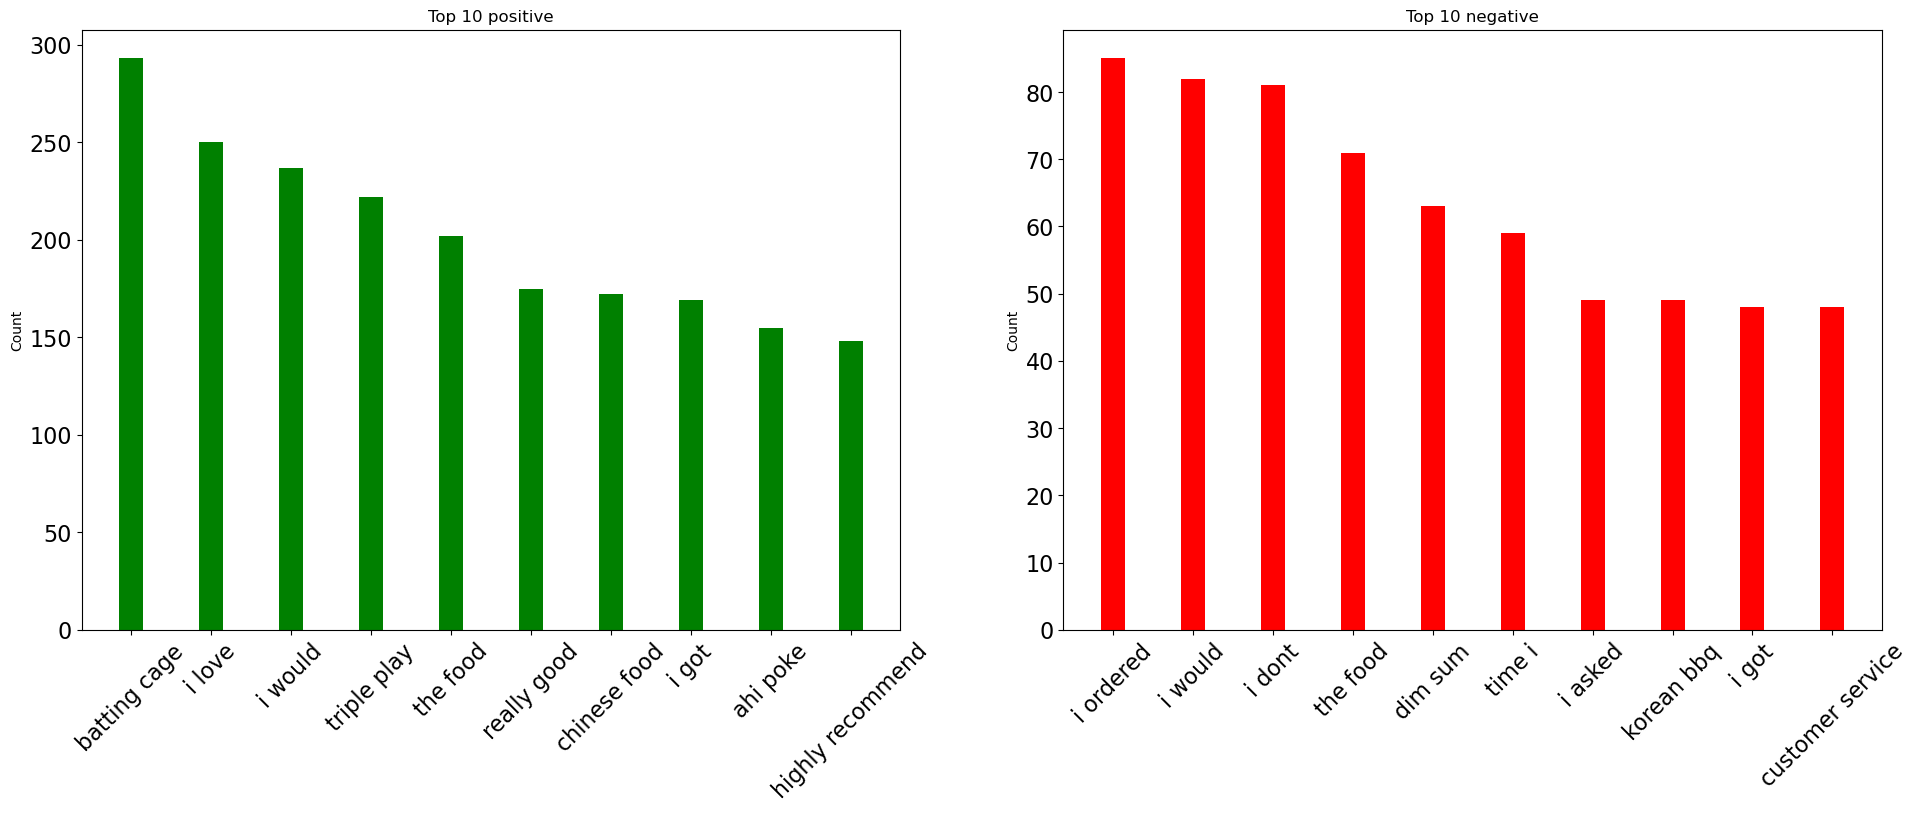

In [26]:
run_ngram(CA_Asian_business_review,2)

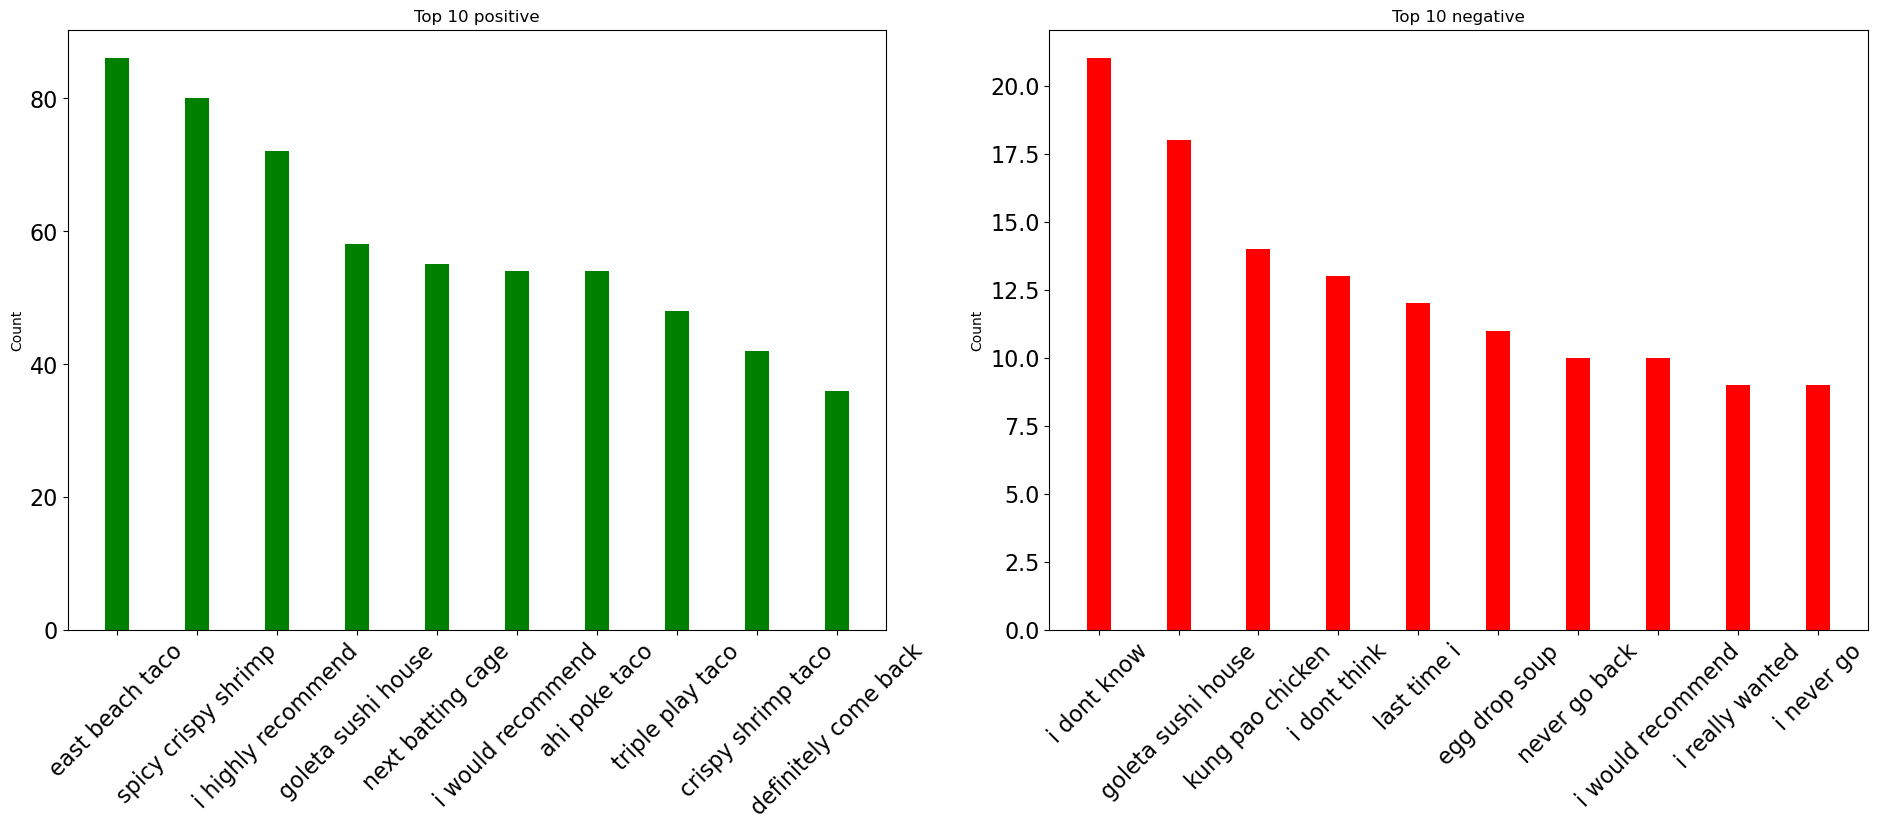

In [27]:
run_ngram(CA_Asian_business_review,3)

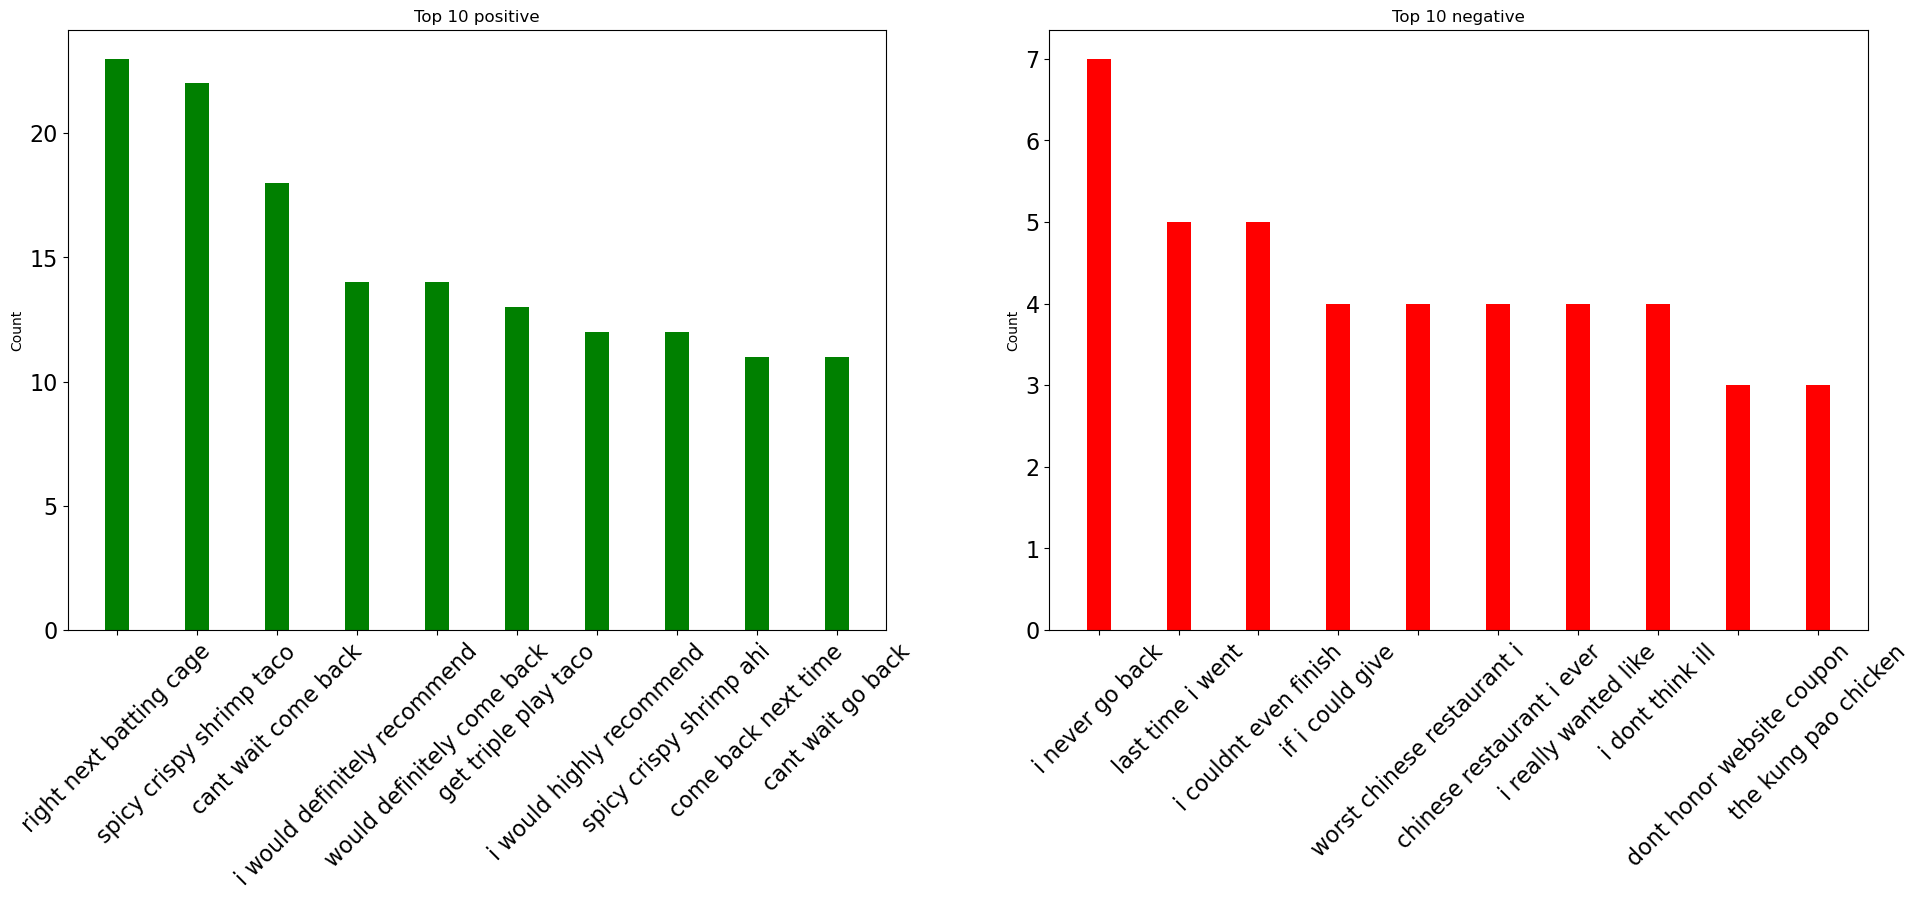

In [28]:
run_ngram(CA_Asian_business_review,4)

# TFIDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,4))
CA_Asian_business_review['text_new'] = [' '.join(map(str,l)) for l in CA_Asian_business_review.text_cleaned]
transformed = tfidf.fit_transform(pd.Series(CA_Asian_business_review.text_new))

tfidf_test_df = pd.DataFrame(transformed[0].T.todense(),index=tfidf.get_feature_names(), columns=["TF-IDF"])
tfidf_test_df = tfidf_test_df.sort_values('TF-IDF', ascending=False)

tfidf_test_df

# Interactive Map

In [ ]:
has_parking = CA_Asian_food[CA_Asian_food['lot'] == True]
no_parking = CA_Asian_food[CA_Asian_food['lot'] == False]

color_scale = [(0, 'orange'), (1,'red')]
fig = px.scatter_mapbox(CA_Asian_food, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="name", 
                        hover_data=["average_stars",'address'],
                        color="lot",
                        color_continuous_scale=color_scale,
                        size="average_stars",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(CA_Asian_food, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="name", 
                        hover_data=["average_stars"],
                        color="average_stars",
                        color_continuous_scale=color_scale,
                        size="average_stars",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()